In [156]:
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model, Sequential
from keras import regularizers, optimizers
from keras.optimizers import Adam, RMSprop
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# File Extracting
So our file is going to be in binary and we are going to need to get it out
You can thinks of this process of encoding and decoding, but allows us to store a large number of images, and the vectors, in a much smaller file

In [38]:
# this is a dictionairy used to define the structure
# of our binary file
feature_description = {
    'image': tf.io.FixedLenFeature([], tf.string),
    'title': tf.io.FixedLenFeature([], tf.string),
    'price': tf.io.FixedLenFeature([], tf.float32),
    'unbalanced_vector': tf.io.VarLenFeature(tf.int64),
    'balanced_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_model_vector': tf.io.VarLenFeature(tf.int64),
    'unbalanced_brand_vector': tf.io.VarLenFeature(tf.int64),
}

In [39]:
# this is a function used to extract the binary information
def parse_example(example_proto):
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)
    image = tf.io.decode_jpeg(parsed_example['image'])
    title = tf.strings.lower(parsed_example['title'])
    price = parsed_example['price']
    unbalanced_vector = tf.sparse.to_dense(parsed_example['unbalanced_vector'])
    balanced_vector = tf.sparse.to_dense(parsed_example['balanced_vector'])
    unbalanced_model_vector = tf.sparse.to_dense(parsed_example['unbalanced_model_vector'])
    unbalanced_brand_vector = tf.sparse.to_dense(parsed_example['unbalanced_brand_vector'])
    return image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector, unbalanced_brand_vector

In [40]:
dataset = tf.data.TFRecordDataset('Downloaded_Images_Binary_Brands&Models.tfrecords')
dataset = dataset.map(parse_example)


# Here some code to show we extracted everything correctly!

Unbalanced Vector: [0 1 0 0 0 0 0 0 0 0]
Balanced Vector: [0 1 0 0 0 0 0 0 0 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
Brand Vector: [1 0 0 0 0 0]
tf.Tensor(107.0, shape=(), dtype=float32)


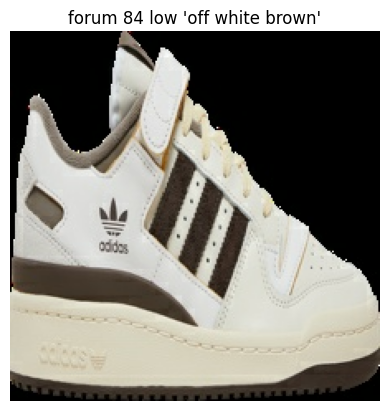

In [41]:
for image, title, price, unbalanced_vector, balanced_vector,unbalanced_model_vector,unbalanced_brand_vector in dataset.take(1):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

# Splitting up training and Testing Data
    * We are going to shuffle the data incase
    the website organizes the data in set, non-random
    way. 

## Base Dataset
    * No techniques except shuffling and shape!

In [42]:
# Size of Data
buffer_size = sum([1 for _ in dataset])  
# Shuffle the data
shuffled_dataset = dataset.shuffle(buffer_size, reshuffle_each_iteration=False)
# 80/20 Split, Taking will take the first 80% and skip will take the last
train_size = int(0.8 * buffer_size)
train_dataset = shuffled_dataset.take(train_size)
val_dataset = shuffled_dataset.skip(train_size)

## Printing it out again to make sure everything looks right!

Unbalanced Vector: [0 0 0 0 0 0 1 0 0 0]
Balanced Vector: [0 0 0 0 0 0 0 0 1 0]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
Brand Vector: [0 0 0 0 1 0]
tf.Tensor(607.0, shape=(), dtype=float32)


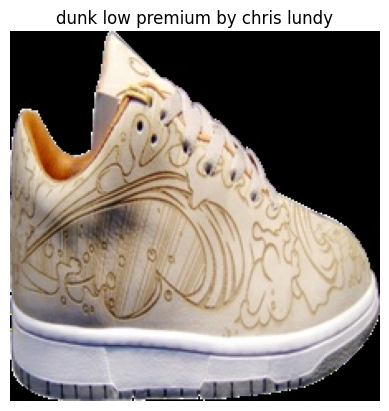

Unbalanced Vector: [0 0 0 0 0 0 0 0 0 1]
Balanced Vector: [0 0 0 0 0 0 0 0 0 1]
Model Vector: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
Brand Vector: [0 0 0 0 1 0]
tf.Tensor(2006.0, shape=(), dtype=float32)


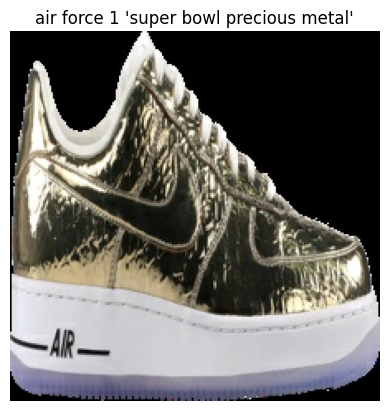

Unbalanced Vector: [0 0 0 1 0 0 0 0 0 0]
Balanced Vector: [0 0 0 0 0 0 1 0 0 0]
Model Vector: [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Brand Vector: [0 1 0 0 0 0]
tf.Tensor(301.0, shape=(), dtype=float32)


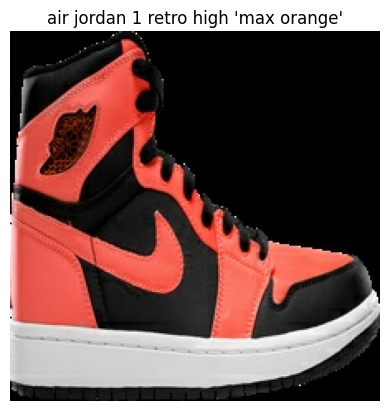

In [43]:
for image, title, price, unbalanced_vector, balanced_vector, unbalanced_model_vector,unbalanced_brand_vector in val_dataset.take(3):
    print("Unbalanced Vector:", unbalanced_vector.numpy())
    print("Balanced Vector:", balanced_vector.numpy())
    print("Model Vector:", unbalanced_model_vector.numpy())
    print("Brand Vector:", unbalanced_brand_vector.numpy())
    print(price)
    plt.imshow(image.numpy())
    plt.title(title.numpy().decode('utf-8'))
    plt.axis('off')  
    plt.show()

## Data Technique 1 - Normalization!
* This can be done simply by dividing by 255 (Pixel score)
* This will improve and is going to be necessary for vgg16

In [44]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

unbalanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
unbalanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [45]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector

balanced_vector_train_dataset = train_dataset.map(preprocess).batch(16)
balanced_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [46]:
# This is a function to divide the image / 255, preprocess is 
# a function apart of keras and has certain rules, and it allows us to declare are predictor/response
# we are going to be using these keras functions a lot
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector

brand_vector_train_dataset = train_dataset.map(preprocess).batch(16)
brand_vector_val_dataset = val_dataset.map(preprocess).batch(16)

In [47]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector

model_vector_train_dataset = train_dataset.map(preprocess).batch(16)
model_vector_val_dataset = val_dataset.map(preprocess).batch(16)

## Data Technique 2 - Data Augmentaton!
* This is a technique used to introduce variations to our training data and can have enourmouse
benefits

DID NOT HELP WITH THIS MODEL, KEEPING TO SHOW WHAT IT DOES

In [48]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector,unbalanced_brand_vector, augment = True):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    if augment:
        image = tf.image.random_flip_left_right(image)  
        image = tf.image.random_flip_up_down(image) 
        # image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
       
        # image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
        
    return image, unbalanced_brand_vector

aug_train_dataset = train_dataset.map(preprocess).batch(16)
aug_val_dataset = val_dataset.map(preprocess).batch(16)



## Data Technique 3 - Class Weights!
* This is a technique used to balance data by providing a weight based on class size
* DID NOT HELP KEEPING TO SHOW WHAT IT DOES


In [49]:
# counts for our vector
class_counts = {
    'A':258,
    'B':489,
    'C':88,
    'D':115,
    'E':1390,
    'F':46,
}
# code to get the weights for each class
total_samples = sum(class_counts.values())
num_classes = len(class_counts)
class_weights = {class_label: (total_samples / (num_classes * count)) for class_label, count in class_counts.items()}
class_weights = {i: weight for i, (_, weight) in enumerate(class_weights.items())}

# Models
We are going to be using Tensorflow and Keras to build our model. Tensflow Keras allow us to build models incredibly easly. 
Each dataset will have two models (8 models)
1. Model 
    * Took from https://github.com/bnsreenu/python_for_microscopists/blob/master/142-multi_label_classification.py (slightly modified)
2. Modified Model
    * Experimented modifcatons such as Kernal size, 
    max pooling size, number of filters, dropout, 
    addtional dense layers and more. 
    * filter size was the most successful modification


## Unbalanced Price Models

In [50]:
# model is linear
unbalanced_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
unbalanced_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
unbalanced_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
unbalanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
unbalanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
unbalanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
unbalanced_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_vector)
# (6400) -> (10) output layers
unbalanced_model.add(Dense(vector_size, activation='softmax'))

unbalanced_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
unbalanced_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization_32 (Ba  (None, 220, 220, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_33 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_33 (MaxPooli  (None, 53, 53, 32)       

In [51]:
# model is linear
unbalanced_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 4, 4, outputs (220,220,16) (NO PADDING)
unbalanced_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 4, 4, outputs (106,106,32) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 4, 4, outputs (49,49,64) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 4, 4, outputs (20,20,64) (NO PADDING)
unbalanced_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
unbalanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
unbalanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
unbalanced_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
unbalanced_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_vector)
# (6400) -> (10) output layers
unbalanced_model_modified.add(Dense(vector_size, activation='softmax'))
unbalanced_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
unbalanced_model_modified.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_36 (Ba  (None, 221, 221, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_36 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_36 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 53, 53, 32)       

## Balanced Models

In [52]:
# model is linear
balanced_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
balanced_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
balanced_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
balanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
balanced_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
balanced_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
balanced_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(balanced_vector)
# (6400) -> (10) output layers
balanced_model.add(Dense(vector_size, activation='softmax'))

balanced_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
balanced_model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization_40 (Ba  (None, 220, 220, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_40 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_41 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 53, 53, 32)      

In [53]:
# model is linear
balanced_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 4, 4, outputs (220,220,16) (NO PADDING)
balanced_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 4, 4, outputs (106,106,32) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 4, 4, outputs (49,49,64) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 4, 4, outputs (20,20,64) (NO PADDING)
balanced_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
balanced_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
balanced_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
balanced_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
balanced_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(balanced_vector)
# (6400) -> (10) output layers
balanced_model_modified.add(Dense(vector_size, activation='softmax'))
balanced_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
balanced_model_modified.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_44 (Ba  (None, 221, 221, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_44 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_45 (Conv2D)          (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 53, 53, 32)      

## Brand Model

In [54]:
# model is linear
brand_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
brand_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
brand_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
brand_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
brand_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
brand_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
brand_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_brand_vector)
# (6400) -> (10) output layers
brand_model.add(Dense(vector_size, activation='softmax'))

brand_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
brand_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_48 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization_48 (Ba  (None, 220, 220, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_48 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_48 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_49 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_49 (MaxPooli  (None, 53, 53, 32)      

In [55]:
# model_test is linear
brand_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
brand_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
brand_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
brand_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
brand_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
brand_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
brand_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
brand_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
brand_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_brand_vector)
# (6400) -> (10) output layers
brand_model_modified.add(Dense(vector_size, activation='softmax'))
brand_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
brand_model_modified.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_52 (Conv2D)          (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_52 (Ba  (None, 221, 221, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_52 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_52 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_53 (Conv2D)          (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_53 (MaxPooli  (None, 53, 53, 32)      

## Model Model

In [56]:
# model is linear
model_model = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
model_model.add(Conv2D(16, (5, 5), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
model_model.add(Conv2D(filters=32, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
model_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
model_model.add(Conv2D(filters=64, kernel_size=(5, 5), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
model_model.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model.add(Dropout(0.2))
# (10,10,64) -> (6400)
model_model.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_model_vector)
# (6400) -> (10) output layers
model_model.add(Dense(vector_size, activation='softmax'))

model_model.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
model_model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 220, 220, 16)      1216      
                                                                 
 batch_normalization_56 (Ba  (None, 220, 220, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_56 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_56 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_57 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 max_pooling2d_57 (MaxPooli  (None, 53, 53, 32)      

In [57]:
# model_test is linear
model_model_modified = Sequential()
# input shape is the shape of our imaages
image_shape = (224, 224, 3)

# First block
# Filter Layer, 16 filters of size 5, 5, outputs (220,220,16) (NO PADDING)
model_model_modified.add(Conv2D(16, (4, 4), activation='relu', input_shape = image_shape))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Max Pooling Layer to shrink our feature maps in half (220,220,16) -> (110,110,16)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(.2))

# Filter Layer, 32 filters of size 5, 5, outputs (106,106,32) (NO PADDING)
model_model_modified.add(Conv2D(filters=32, kernel_size=(4, 4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (106,106,32) -> (53,53,32)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))


# Filter Layer, 64 filters of size 5, 5, outputs (49,49,64) (NO PADDING)
model_model_modified.add(Conv2D(filters=64, kernel_size=(4, 4), activation="relu"))
# Max Pooling Layer to shrink our feature maps in half (49,49,64) -> (24,24,64)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))

# Filter Layer, 64 filters of size 5, 5, outputs (20,20,64) (NO PADDING)
model_model_modified.add(Conv2D(filters=64, kernel_size=(4,4), activation='relu'))
# Max Pooling Layer to shrink our feature maps in half (20,20,64) -> (10,10,64)
model_model_modified.add(MaxPooling2D(pool_size=(2, 2)))
# Batch Normalizing to roughly mean of zero, dev 1 
model_model_modified.add(BatchNormalization())
# Randomly droping out values in our 16 feature maps (Making them zero)
model_model_modified.add(Dropout(0.2))
# (10,10,64) -> (6400)
model_model_modified.add(Flatten())
## Size of Our vector, number of labels (10)
vector_size = tf.size(unbalanced_model_vector)
# (6400) -> (10) output layers
model_model_modified.add(Dense(vector_size, activation='softmax'))
model_model_modified.compile(optimizer=Adam(),loss="binary_crossentropy",metrics=["accuracy"])
model_model_modified.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_60 (Conv2D)          (None, 221, 221, 16)      784       
                                                                 
 batch_normalization_60 (Ba  (None, 221, 221, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_60 (MaxPooli  (None, 110, 110, 16)      0         
 ng2D)                                                           
                                                                 
 dropout_60 (Dropout)        (None, 110, 110, 16)      0         
                                                                 
 conv2d_61 (Conv2D)          (None, 107, 107, 32)      8224      
                                                                 
 max_pooling2d_61 (MaxPooli  (None, 53, 53, 32)      

# Running the models and making predictions

In [58]:
early_stopping_callback = EarlyStopping(monitor='val_loss', 
                                        patience= 2, 
                                        restore_best_weights=True)

## Unbalanced Price Models and Predictions

In [59]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
unbalanced_model.fit(unbalanced_vector_train_dataset, epochs=9, validation_data=unbalanced_vector_val_dataset, callbacks=[early_stopping_callback])

Epoch 1/9


2023-11-25 10:44:35.545160: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 26s 41ms/step - loss: 0.3670 - accuracy: 0.2560

2023-11-25 10:45:00.925730: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8451628978196107773
2023-11-25 10:45:00.925746: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12907931502660809443
2023-11-25 10:45:00.925752: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195
2023-11-25 10:45:00.925756: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8615042601713452717
2023-11-25 10:45:00.925763: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 957038110520510285
2023-11-25 10:45:00.925781: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13913186548401822293
2023-11-25 10:45:00.925790: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

597/597 [==============================] - 29s 47ms/step - loss: 0.3670 - accuracy: 0.2560 - val_loss: 0.8825 - val_accuracy: 0.0457
Epoch 2/9


2023-11-25 10:45:04.476652: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 10:45:04.476669: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 10:45:04.476674: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 10:45:04.476681: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14262311152134288725
2023-11-25 10:45:04.476690: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 10:45:04.476701: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624


597/597 [==============================] - 28s 45ms/step - loss: 0.3166 - accuracy: 0.2842 - val_loss: 0.3209 - val_accuracy: 0.3097
Epoch 3/9
597/597 [==============================] - 26s 43ms/step - loss: 0.2844 - accuracy: 0.3256 - val_loss: 0.3430 - val_accuracy: 0.2448
Epoch 4/9
597/597 [==============================] - 26s 43ms/step - loss: 0.2675 - accuracy: 0.3644 - val_loss: 0.3155 - val_accuracy: 0.2997
Epoch 5/9
597/597 [==============================] - 27s 44ms/step - loss: 0.2551 - accuracy: 0.3975 - val_loss: 0.3039 - val_accuracy: 0.3143
Epoch 6/9
597/597 [==============================] - 26s 42ms/step - loss: 0.2440 - accuracy: 0.4263 - val_loss: 0.2952 - val_accuracy: 0.3248
Epoch 7/9
597/597 [==============================] - 26s 43ms/step - loss: 0.2304 - accuracy: 0.4639 - val_loss: 0.3018 - val_accuracy: 0.3064
Epoch 8/9
597/597 [==============================] - 26s 43ms/step - loss: 0.2108 - accuracy: 0.5265 - val_loss: 0.3069 - val_accuracy: 0.2745


In [60]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
unbalanced_model_modified.fit(unbalanced_vector_train_dataset, epochs=9, validation_data=unbalanced_vector_val_dataset, callbacks=[early_stopping_callback]) 

Epoch 1/9


2023-11-25 10:48:11.546020: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 22s 34ms/step - loss: 0.3855 - accuracy: 0.2519

2023-11-25 10:48:33.191235: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8451628978196107773
2023-11-25 10:48:33.191248: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6456058041753617151
2023-11-25 10:48:33.191252: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195
2023-11-25 10:48:33.191255: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8615042601713452717
2023-11-25 10:48:33.191259: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 957038110520510285
2023-11-25 10:48:33.191264: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13913186548401822293
2023-11-25 10:48:33.191267: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

597/597 [==============================] - 25s 39ms/step - loss: 0.3855 - accuracy: 0.2519 - val_loss: 1.0138 - val_accuracy: 0.0222
Epoch 2/9


2023-11-25 10:48:36.174196: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 10:48:36.174212: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 10:48:36.174218: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 10:48:36.174221: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 16766941129915373525
2023-11-25 10:48:36.174226: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 10:48:36.174238: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624


597/597 [==============================] - 24s 39ms/step - loss: 0.3193 - accuracy: 0.2943 - val_loss: 0.3016 - val_accuracy: 0.3122
Epoch 3/9
597/597 [==============================] - 24s 39ms/step - loss: 0.2815 - accuracy: 0.3436 - val_loss: 0.2837 - val_accuracy: 0.3198
Epoch 4/9
597/597 [==============================] - 24s 38ms/step - loss: 0.2583 - accuracy: 0.3881 - val_loss: 0.2825 - val_accuracy: 0.3198
Epoch 5/9
597/597 [==============================] - 24s 38ms/step - loss: 0.2422 - accuracy: 0.4356 - val_loss: 0.2944 - val_accuracy: 0.2804
Epoch 6/9
597/597 [==============================] - 25s 40ms/step - loss: 0.2263 - accuracy: 0.4820 - val_loss: 0.3101 - val_accuracy: 0.2632


In [61]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_vector

unbalanced_predictions_dataset = shuffled_dataset.map(preprocess).batch(16)

In [232]:
predictions = unbalanced_model.predict(unbalanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
unbalanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    unbalanced_binary_predictions[i, max_index] = 1

print(unbalanced_binary_predictions)

746/746 [==============================] - 8s 10ms/step
[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


2023-11-25 13:31:00.375886: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


In [233]:
predictions = unbalanced_model_modified.predict(unbalanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
unbalanced_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    unbalanced_binary_mod_predictions[i, max_index] = 1

print(unbalanced_binary_mod_predictions)

746/746 [==============================] - 8s 10ms/step
[[0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


2023-11-25 13:31:09.757546: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


## Balanced Price Models and Predictions

In [64]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
balanced_model.fit(balanced_vector_train_dataset, epochs=9, validation_data=balanced_vector_val_dataset, callbacks=[early_stopping_callback])

Epoch 1/9


2023-11-25 10:50:54.255720: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 25s 38ms/step - loss: 0.4273 - accuracy: 0.1182

2023-11-25 10:51:18.278610: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12514087768433058172
2023-11-25 10:51:18.278625: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3990573463368269370
2023-11-25 10:51:18.278650: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8451628978196107773
2023-11-25 10:51:18.278656: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6456058041753617151
2023-11-25 10:51:18.278659: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195
2023-11-25 10:51:18.278663: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8615042601713452717
2023-11-25 10:51:18.278666: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

597/597 [==============================] - 28s 43ms/step - loss: 0.4273 - accuracy: 0.1182 - val_loss: 0.6658 - val_accuracy: 0.0884
Epoch 2/9


2023-11-25 10:51:21.393379: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 14815244597068460283
2023-11-25 10:51:21.393399: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 10:51:21.393403: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 10:51:21.393408: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 10:51:21.393413: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 10:51:21.393425: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624


597/597 [==============================] - 26s 43ms/step - loss: 0.3620 - accuracy: 0.1563 - val_loss: 0.3457 - val_accuracy: 0.1484
Epoch 3/9
597/597 [==============================] - 27s 43ms/step - loss: 0.3300 - accuracy: 0.1889 - val_loss: 0.3253 - val_accuracy: 0.1689
Epoch 4/9
597/597 [==============================] - 27s 43ms/step - loss: 0.3093 - accuracy: 0.2326 - val_loss: 0.3261 - val_accuracy: 0.1664
Epoch 5/9
597/597 [==============================] - 27s 43ms/step - loss: 0.2963 - accuracy: 0.2735 - val_loss: 0.3293 - val_accuracy: 0.1727


In [65]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
balanced_model_modified.fit(balanced_vector_train_dataset, epochs=9, validation_data=balanced_vector_val_dataset, callbacks=[early_stopping_callback]) 

Epoch 1/9


2023-11-25 10:53:08.207589: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 22s 35ms/step - loss: 0.4493 - accuracy: 0.1177

2023-11-25 10:53:30.124558: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9628981483315026686
2023-11-25 10:53:30.124575: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3990573463368269370
2023-11-25 10:53:30.124589: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2315814997994458939
2023-11-25 10:53:30.124595: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13913186548401822293
2023-11-25 10:53:30.124604: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6456058041753617151
2023-11-25 10:53:30.124608: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195
2023-11-25 10:53:30.124611: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

597/597 [==============================] - 26s 40ms/step - loss: 0.4493 - accuracy: 0.1177 - val_loss: 0.8384 - val_accuracy: 0.1077
Epoch 2/9


2023-11-25 10:53:33.246423: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 10:53:33.246437: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 10:53:33.246442: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 10:53:33.246446: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 10:53:33.246454: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624
2023-11-25 10:53:33.246457: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13749880109533321206


597/597 [==============================] - 24s 39ms/step - loss: 0.3707 - accuracy: 0.1595 - val_loss: 0.3618 - val_accuracy: 0.1471
Epoch 3/9
597/597 [==============================] - 24s 39ms/step - loss: 0.3281 - accuracy: 0.2015 - val_loss: 0.3333 - val_accuracy: 0.1266
Epoch 4/9
597/597 [==============================] - 24s 39ms/step - loss: 0.3043 - accuracy: 0.2504 - val_loss: 0.3853 - val_accuracy: 0.1199
Epoch 5/9
597/597 [==============================] - 24s 39ms/step - loss: 0.2885 - accuracy: 0.3074 - val_loss: 0.3411 - val_accuracy: 0.1249


In [66]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, balanced_vector

balanced_predictions_dataset = shuffled_dataset.map(preprocess).batch(16)

In [228]:
predictions = balanced_model.predict(balanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
balanced_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    balanced_binary_predictions[i, max_index] = 1

print(balanced_binary_predictions)


746/746 [==============================] - 8s 10ms/step
[[0 0 1 ... 0 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


2023-11-25 13:29:46.761576: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


In [229]:
predictions = balanced_model_modified.predict(balanced_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
balanced_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    balanced_binary_mod_predictions[i, max_index] = 1

print(balanced_binary_mod_predictions)

746/746 [==============================] - 8s 10ms/step
[[0 0 0 ... 1 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


2023-11-25 13:29:57.292083: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


## Brand Models and Predictions

In [69]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
brand_model.fit(brand_vector_train_dataset, epochs=9, validation_data=brand_vector_val_dataset, callbacks=[early_stopping_callback])

Epoch 1/9


2023-11-25 10:55:27.391643: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 25s 38ms/step - loss: 0.1831 - accuracy: 0.8118

2023-11-25 10:55:51.757183: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 17373207372443186240
2023-11-25 10:55:51.757196: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8451628978196107773
2023-11-25 10:55:51.757200: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6456058041753617151
2023-11-25 10:55:51.757204: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195
2023-11-25 10:55:51.757211: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8615042601713452717
2023-11-25 10:55:51.757215: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 957038110520510285
2023-11-25 10:55:51.757221: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

597/597 [==============================] - 28s 44ms/step - loss: 0.1831 - accuracy: 0.8118 - val_loss: 0.9859 - val_accuracy: 0.3868
Epoch 2/9


2023-11-25 10:55:54.837079: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 10:55:54.837094: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 10:55:54.837099: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 10:55:54.837133: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 2244842555880161259
2023-11-25 10:55:54.837144: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 10:55:54.837154: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624


597/597 [==============================] - 26s 43ms/step - loss: 0.0630 - accuracy: 0.9466 - val_loss: 0.0873 - val_accuracy: 0.9279
Epoch 3/9
597/597 [==============================] - 26s 42ms/step - loss: 0.0293 - accuracy: 0.9812 - val_loss: 0.0651 - val_accuracy: 0.9564
Epoch 4/9
597/597 [==============================] - 26s 42ms/step - loss: 0.0154 - accuracy: 0.9917 - val_loss: 0.0530 - val_accuracy: 0.9635
Epoch 5/9
597/597 [==============================] - 26s 42ms/step - loss: 0.0141 - accuracy: 0.9954 - val_loss: 0.0523 - val_accuracy: 0.9652
Epoch 6/9
597/597 [==============================] - 26s 42ms/step - loss: 0.0123 - accuracy: 0.9966 - val_loss: 0.0700 - val_accuracy: 0.9589
Epoch 7/9
597/597 [==============================] - 26s 42ms/step - loss: 0.0148 - accuracy: 0.9956 - val_loss: 0.0625 - val_accuracy: 0.9661


In [70]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
brand_model_modified.fit(brand_vector_train_dataset, epochs=9, validation_data=brand_vector_val_dataset, callbacks=[early_stopping_callback]) 

Epoch 1/9


2023-11-25 10:58:33.113633: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 35ms/step - loss: 0.1961 - accuracy: 0.8036

2023-11-25 10:58:55.258503: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8451628978196107773
2023-11-25 10:58:55.258517: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195
2023-11-25 10:58:55.258521: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8615042601713452717
2023-11-25 10:58:55.258527: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 957038110520510285
2023-11-25 10:58:55.258531: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13913186548401822293
2023-11-25 10:58:55.258534: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 12208413650881256849
2023-11-25 10:58:55.258539: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv i

597/597 [==============================] - 26s 40ms/step - loss: 0.1961 - accuracy: 0.8036 - val_loss: 0.8138 - val_accuracy: 0.4635
Epoch 2/9


2023-11-25 10:58:58.378618: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 10:58:58.378637: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 10:58:58.378642: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 10:58:58.378646: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 10:58:58.378654: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624
2023-11-25 10:58:58.378657: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13946509757988806196


597/597 [==============================] - 24s 39ms/step - loss: 0.0708 - accuracy: 0.9430 - val_loss: 0.1066 - val_accuracy: 0.9422
Epoch 3/9
597/597 [==============================] - 24s 39ms/step - loss: 0.0347 - accuracy: 0.9759 - val_loss: 0.0744 - val_accuracy: 0.9531
Epoch 4/9
597/597 [==============================] - 24s 39ms/step - loss: 0.0165 - accuracy: 0.9929 - val_loss: 0.0673 - val_accuracy: 0.9581
Epoch 5/9
597/597 [==============================] - 24s 39ms/step - loss: 0.0135 - accuracy: 0.9945 - val_loss: 0.0748 - val_accuracy: 0.9585
Epoch 6/9
597/597 [==============================] - 24s 39ms/step - loss: 0.0126 - accuracy: 0.9957 - val_loss: 0.0752 - val_accuracy: 0.9547


In [71]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_brand_vector

brand_predictions_dataset = shuffled_dataset.map(preprocess).batch(16)

In [226]:
predictions = brand_model.predict(brand_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
brand_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    brand_binary_predictions[i, max_index] = 1

print(brand_binary_predictions)

746/746 [==============================] - 8s 10ms/step
[[0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


2023-11-25 13:29:12.982913: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


In [227]:
predictions = brand_model_modified.predict(brand_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
brand_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    brand_binary_mod_predictions [i, max_index] = 1

print(brand_binary_mod_predictions )

746/746 [==============================] - 8s 10ms/step
[[0 0 0 0 1 0]
 [0 0 1 0 0 0]
 [0 0 0 0 1 0]
 ...
 [0 1 0 0 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


2023-11-25 13:29:22.470085: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


## Model Models and Predictions

In [74]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
model_model.fit(model_vector_train_dataset, epochs=9, validation_data=model_vector_val_dataset, callbacks=[early_stopping_callback])

Epoch 1/9


2023-11-25 11:01:15.709586: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 25s 39ms/step - loss: 0.0897 - accuracy: 0.6725

2023-11-25 11:01:40.403797: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6456058041753617151
2023-11-25 11:01:40.403813: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13913186548401822293
2023-11-25 11:01:40.403817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195


597/597 [==============================] - 28s 44ms/step - loss: 0.0897 - accuracy: 0.6725 - val_loss: 0.0889 - val_accuracy: 0.7209
Epoch 2/9


2023-11-25 11:01:43.598287: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18294638950943779058
2023-11-25 11:01:43.598303: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 11:01:43.598307: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 11:01:43.598313: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 11:01:43.598318: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 11:01:43.598324: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624


597/597 [==============================] - 27s 43ms/step - loss: 0.0285 - accuracy: 0.9195 - val_loss: 0.0284 - val_accuracy: 0.9145
Epoch 3/9
597/597 [==============================] - 27s 43ms/step - loss: 0.0155 - accuracy: 0.9612 - val_loss: 0.0261 - val_accuracy: 0.9267
Epoch 4/9
597/597 [==============================] - 26s 43ms/step - loss: 0.0100 - accuracy: 0.9780 - val_loss: 0.0398 - val_accuracy: 0.9237
Epoch 5/9
597/597 [==============================] - 26s 43ms/step - loss: 0.0087 - accuracy: 0.9828 - val_loss: 0.0300 - val_accuracy: 0.9237


In [75]:
# Running the model, 1 Epoch = Forward Pass, Loss Computer, Backward Pass
model_model_modified.fit(model_vector_train_dataset, epochs=9, validation_data=model_vector_val_dataset, callbacks=[early_stopping_callback])

Epoch 1/9


2023-11-25 11:03:30.013719: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


    597/Unknown - 23s 35ms/step - loss: 0.0801 - accuracy: 0.7298

2023-11-25 11:03:52.229872: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3448218066394490896
2023-11-25 11:03:52.229888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8451628978196107773
2023-11-25 11:03:52.229904: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6456058041753617151
2023-11-25 11:03:52.229908: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 11257086642285479195
2023-11-25 11:03:52.229912: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 8615042601713452717
2023-11-25 11:03:52.229915: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 3990573463368269370
2023-11-25 11:03:52.229929: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv it

597/597 [==============================] - 26s 40ms/step - loss: 0.0801 - accuracy: 0.7298 - val_loss: 0.5689 - val_accuracy: 0.6861
Epoch 2/9


2023-11-25 11:03:55.370817: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18423516913720019479
2023-11-25 11:03:55.370835: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 939416828948986511
2023-11-25 11:03:55.370840: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 6173719759807845575
2023-11-25 11:03:55.370875: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 9715316904274315686
2023-11-25 11:03:55.370888: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18371698806253077624
2023-11-25 11:03:55.370893: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 13307359863055169492


597/597 [==============================] - 24s 39ms/step - loss: 0.0226 - accuracy: 0.9433 - val_loss: 0.0505 - val_accuracy: 0.8621
Epoch 3/9
597/597 [==============================] - 24s 39ms/step - loss: 0.0123 - accuracy: 0.9719 - val_loss: 0.0256 - val_accuracy: 0.9417
Epoch 4/9
597/597 [==============================] - 24s 39ms/step - loss: 0.0096 - accuracy: 0.9806 - val_loss: 0.0282 - val_accuracy: 0.9355
Epoch 5/9
597/597 [==============================] - 24s 39ms/step - loss: 0.0080 - accuracy: 0.9854 - val_loss: 0.0301 - val_accuracy: 0.9380


In [76]:
def preprocess(image, title, price, unbalanced_vector,balanced_vector, unbalanced_model_vector, unbalanced_brand_vector):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) / 255.0
    return image, unbalanced_model_vector

model_predictions_dataset = shuffled_dataset.map(preprocess).batch(16)

In [224]:
predictions = model_model.predict(model_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
model_binary_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    model_binary_predictions[i, max_index] = 1

print(model_binary_predictions)

746/746 [==============================] - 9s 10ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


2023-11-25 13:28:43.590860: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


In [225]:
predictions = model_model_modified.predict(model_predictions_dataset)

# Initialize an array of zeros with the same shape as predictions
model_binary_mod_predictions = np.zeros_like(predictions, dtype=int)

# Iterate over all predictions and set the max value index to 1
for i, prediction in enumerate(predictions):
    max_index = np.argmax(prediction)
    model_binary_mod_predictions[i, max_index] = 1

print(model_binary_mod_predictions)

746/746 [==============================] - 9s 10ms/step
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


2023-11-25 13:28:53.746936: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 7911799541008059026


# Evaluation

## True vs Pred
* Here is some code to extract our labels and predictions. Because we are running our code on batches, we have unpack the batches, we can then covert it from a tf tensor to numpy array
* There are 8 Evaluations total and all will be combined into 1 final evaluation

In [325]:
metrics_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

## Unbalanced Price Model Evaluation

In [326]:
unbalanced_price_list = ['0-100', '100-200', '200-300', '300-400', '400-500', '500-600',
'600-700', '700-800', '800-900', '900+']

### Original

In [327]:
true_labels = []
predicted_labels = []

binary_predictions_list = unbalanced_binary_predictions.tolist()
prediction_count = 0

for batch in unbalanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)


(11926, 10)
(11926, 10)


In [328]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
unbalanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(unbalanced_cm)

[[ 487  933   23    9    6   33    0    3    0    1]
 [ 430 3226   86   48   34   75    0   10    4   13]
 [ 146 1606  187   75   37   92    0    6    3   13]
 [ 131  972   75  111   53   66    1    7    3   14]
 [  61  469   41   34   78   35    0   11    1   11]
 [  32  338   28   14   22   53    1    1    0    9]
 [  23  188   18   10   10   21    3    5    0    5]
 [  25  216   22    5    8   22    1   14    0    5]
 [   6   75    9    2    4    8    0    2    4    3]
 [  83  614   43   42   30   52    3   14    1   72]]


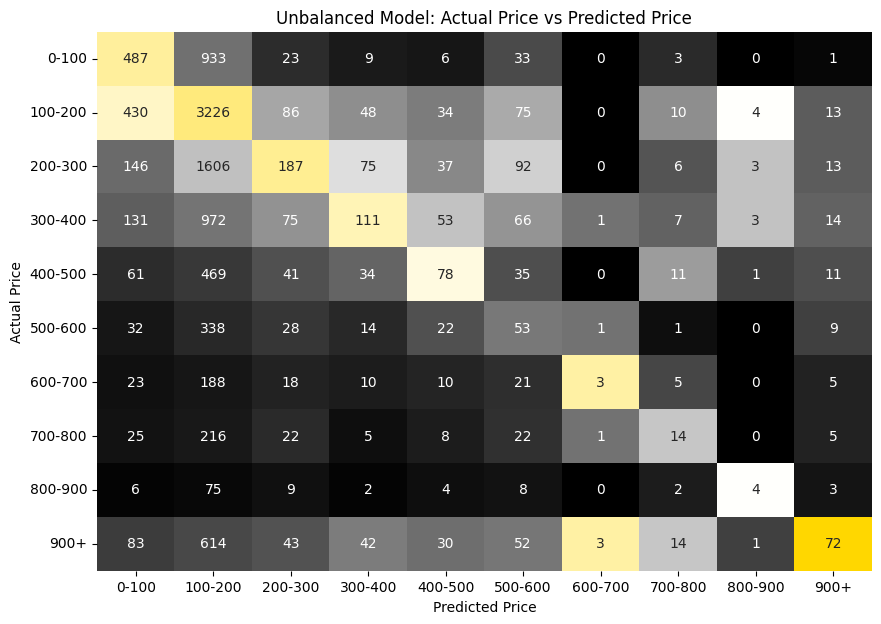

In [329]:
cm_df = pd.DataFrame(unbalanced_cm, index=unbalanced_price_list, columns=unbalanced_price_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Unbalanced Model: Actual Price vs Predicted Price')
plt.show()

In [330]:
unbalanced_accuracy = accuracy_score(true_labels, predicted_labels)
unbalanced_precision = precision_score(true_labels, predicted_labels, average='macro')
unbalanced_recall = recall_score(true_labels, predicted_labels, average='macro')
unbalanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
unbalanced_report = classification_report(true_labels, predicted_labels, target_names=unbalanced_price_list)

unbalanced_metrics = pd.DataFrame([{
    'Model': 'Unbalanced Price Model',
    'Accuracy': unbalanced_accuracy,
    'Precision': unbalanced_precision,
    'Recall': unbalanced_recall,
    'F1 Score': unbalanced_f1
}])
metrics_df = pd.concat([metrics_df, unbalanced_metrics], ignore_index=True)


print(f"Unbalanced Accuracy: {unbalanced_accuracy}")
print(f"Unbalanced Precision: {unbalanced_precision}")
print(f"Unbalanced Recall: {unbalanced_recall}")
print(f"Unbalanced F1 Score: {unbalanced_f1}")
print(unbalanced_report)

Unbalanced Accuracy: 0.3551064900218011
Unbalanced Precision: 0.3044984645587503
Unbalanced Recall: 0.1688472646884575
Unbalanced F1 Score: 0.16590005950075987
              precision    recall  f1-score   support

       0-100       0.34      0.33      0.33      1495
     100-200       0.37      0.82      0.51      3926
     200-300       0.35      0.09      0.14      2165
     300-400       0.32      0.08      0.12      1433
     400-500       0.28      0.11      0.15       741
     500-600       0.12      0.11      0.11       498
     600-700       0.33      0.01      0.02       283
     700-800       0.19      0.04      0.07       318
     800-900       0.25      0.04      0.06       113
        900+       0.49      0.08      0.13       954

   micro avg       0.36      0.36      0.36     11926
   macro avg       0.30      0.17      0.17     11926
weighted avg       0.34      0.36      0.28     11926
 samples avg       0.36      0.36      0.36     11926



/var/folders/9q/kg9gzt1s4d36gdnlr8nf75m40000gn/T/ipykernel_11577/4210602627.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat([metrics_df, unbalanced_metrics], ignore_index=True)


### Modified

In [331]:
true_labels = []
predicted_labels = []

binary_predictions_list = unbalanced_binary_mod_predictions.tolist()
prediction_count = 0

for batch in unbalanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(11926, 10)
(11926, 10)


In [332]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
unbalanced_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(unbalanced_modified_cm)

[[ 322  909  167   43   19   13    1    1    0   20]
 [ 241 2899  493  139   53   25    0    2    0   74]
 [  53 1187  635  153   44   25    0    2    0   66]
 [  39  725  334  213   47   21    0    1    0   53]
 [  21  372  171   76   37   12    0    3    0   49]
 [  20  259  110   50   12   19    0    0    0   28]
 [  15  134   60   39    7    7    2    0    0   19]
 [  11  161   83   23    6   10    0    4    0   20]
 [   6   54   24   11    3    3    0    0    0   12]
 [  25  473  208   79   27   14    1    1    0  126]]


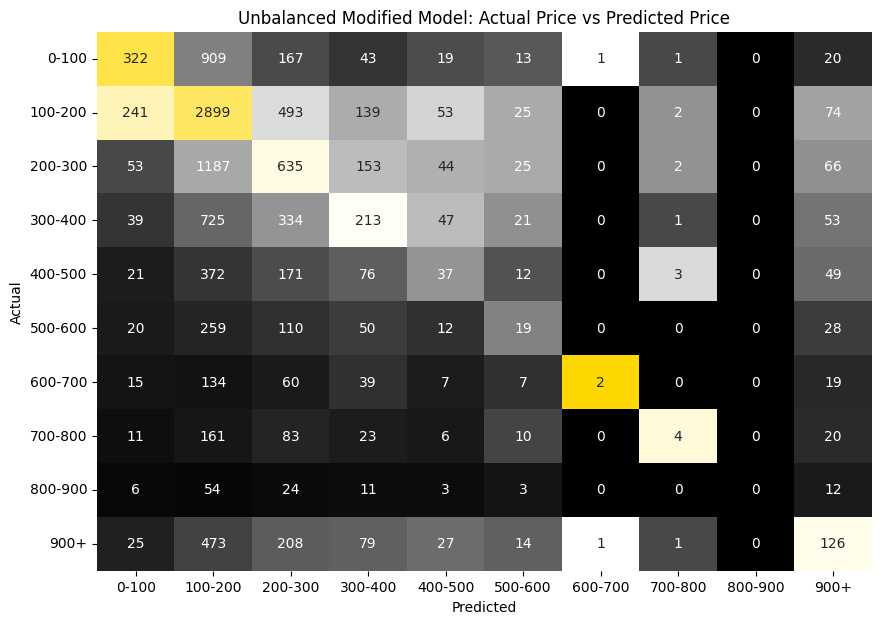

In [333]:
cm_df = pd.DataFrame(unbalanced_modified_cm, index=unbalanced_price_list, columns=unbalanced_price_list)
column_sums = cm_df.sum(axis=0)
cm_df_normalized = cm_df.div(column_sums.where(column_sums != 0, 1), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Unbalanced Modified Model: Actual Price vs Predicted Price')
plt.show()

In [334]:
unbalanced_modified_accuracy = accuracy_score(true_labels, predicted_labels)
unbalanced_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
unbalanced_modified_report = classification_report(true_labels, predicted_labels, target_names=unbalanced_price_list)

unbalanced_modified_metrics = pd.DataFrame([{
    'Model': 'Unbalanced Modified Price Model',
    'Accuracy': unbalanced_modified_accuracy,
    'Precision': unbalanced_modified_precision,
    'Recall': unbalanced_modified_recall,
    'F1 Score': unbalanced_modified_f1
}])
metrics_df = pd.concat([metrics_df, unbalanced_modified_metrics], ignore_index=True)



print(f"Unbalanced Modified Accuracy: {unbalanced_modified_accuracy}")
print(f"Unbalanced Modified Precision: {unbalanced_modified_precision}")
print(f"Unbalanced Modified Recall: {unbalanced_modified_recall}")
print(f"Unbalanced Modified F1 Score: {unbalanced_modified_f1}")
print(unbalanced_modified_report)

Unbalanced Modified Accuracy: 0.3569511990608754
Unbalanced Modified Precision: 0.2695682287016813
Unbalanced Modified Recall: 0.1635543330167702
Unbalanced Modified F1 Score: 0.1631241918530124
              precision    recall  f1-score   support

       0-100       0.43      0.22      0.29      1495
     100-200       0.40      0.74      0.52      3926
     200-300       0.28      0.29      0.29      2165
     300-400       0.26      0.15      0.19      1433
     400-500       0.15      0.05      0.07       741
     500-600       0.13      0.04      0.06       498
     600-700       0.50      0.01      0.01       283
     700-800       0.29      0.01      0.02       318
     800-900       0.00      0.00      0.00       113
        900+       0.27      0.13      0.18       954

   micro avg       0.36      0.36      0.36     11926
   macro avg       0.27      0.16      0.16     11926
weighted avg       0.32      0.36      0.30     11926
 samples avg       0.36      0.36      0.36    

/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/kelley/anaconda3/envs/snakeEnv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Balanced Price Model Evaluation

In [335]:
balanced_price_list = ['17-93', '93-116', '116-143', '143-177', '177-217', '217-272',
'272-340', '340-457', '457-766', '766+']

### Original 

In [336]:
true_labels = []
predicted_labels = []

binary_predictions_list = balanced_binary_predictions.tolist()
prediction_count = 0

for batch in balanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(11926, 10)
(11926, 10)


In [337]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
balanced_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(balanced_cm)

[[424 162 177 137   3   9 135  66  87   9]
 [224 266 190 155   5   9 186  82  98  13]
 [166 178 264 182   2   6 199  58  88  16]
 [133 161 211 245   2  13 219  76  88  20]
 [ 77 134 175 233  17  18 299 101 124  19]
 [ 64 138 125 240   4  69 295 111 131  28]
 [ 70  97 109 186   2  22 394 128 139  35]
 [ 59  85 141 160   9  17 286 219 201  34]
 [ 65  91  97 142   3  14 265 126 304  63]
 [ 83 113  83 165   2  18 259 122 211 141]]


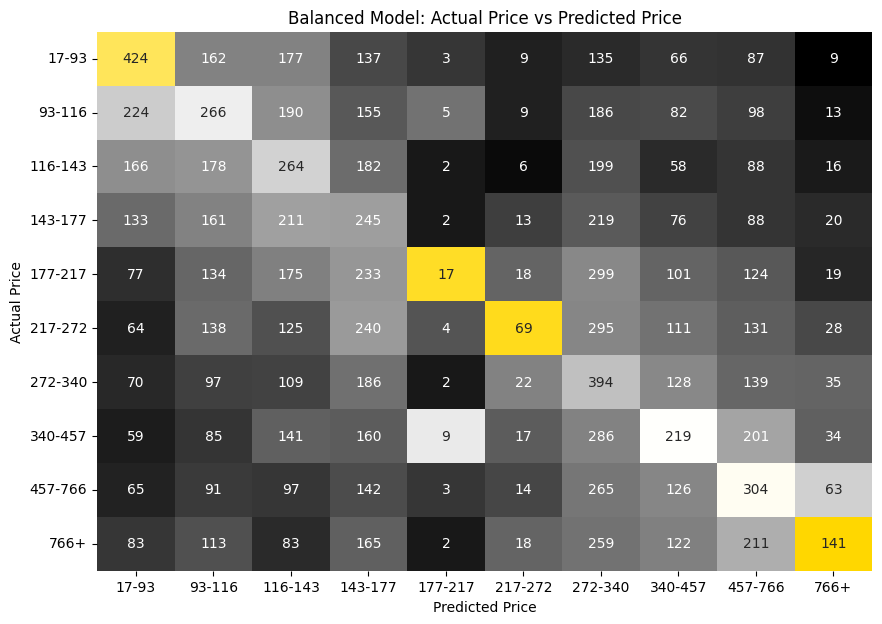

In [338]:
cm_df = pd.DataFrame(balanced_cm, index=balanced_price_list, columns=balanced_price_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Balanced Model: Actual Price vs Predicted Price')
plt.show()

In [339]:
balanced_accuracy = accuracy_score(true_labels, predicted_labels)
balanced_precision = precision_score(true_labels, predicted_labels, average='macro')
balanced_recall = recall_score(true_labels, predicted_labels, average='macro')
balanced_f1 = f1_score(true_labels, predicted_labels, average='macro')
balanced_report = classification_report(true_labels, predicted_labels, target_names=balanced_price_list)

balanced_metrics = pd.DataFrame([{
    'Model': 'Balanced Price Model',
    'Accuracy': balanced_accuracy,
    'Precision': balanced_precision,
    'Recall': balanced_recall,
    'F1 Score': balanced_f1
}])
metrics_df = pd.concat([metrics_df, balanced_metrics], ignore_index=True)

print(f"Balanced Accuracy: {balanced_accuracy}")
print(f"Balanced Precision: {balanced_precision}")
print(f"Balanced Recall: {balanced_recall}")
print(f"Balanced F1 Score: {balanced_f1}")
print(balanced_report)

Balanced Accuracy: 0.19646151266141204
Balanced Precision: 0.2434886039098283
Balanced Recall: 0.19681210247566966
Balanced F1 Score: 0.1823382310022692
              precision    recall  f1-score   support

       17-93       0.31      0.35      0.33      1209
      93-116       0.19      0.22      0.20      1228
     116-143       0.17      0.23      0.19      1159
     143-177       0.13      0.21      0.16      1168
     177-217       0.35      0.01      0.03      1197
     217-272       0.35      0.06      0.10      1205
     272-340       0.16      0.33      0.21      1182
     340-457       0.20      0.18      0.19      1211
     457-766       0.21      0.26      0.23      1170
        766+       0.37      0.12      0.18      1197

   micro avg       0.20      0.20      0.20     11926
   macro avg       0.24      0.20      0.18     11926
weighted avg       0.24      0.20      0.18     11926
 samples avg       0.20      0.20      0.20     11926



### Modified 

In [340]:
true_labels = []
predicted_labels = []

binary_predictions_list = balanced_binary_mod_predictions.tolist()
prediction_count = 0

for batch in balanced_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(11926, 10)
(11926, 10)


In [341]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
balanced_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(balanced_modified_cm)

[[105 156  14 239   1   2  46 574  40  32]
 [ 36 196  15 270   0   1  58 556  50  46]
 [ 14 153  26 320   3   4  72 503  33  31]
 [ 16 114   8 365   1   6  69 514  33  42]
 [ 13  96  13 315   6   3 116 519  64  52]
 [  6  93  10 301   4  16  97 556  68  54]
 [  5  63   8 250   1   8 160 549  70  68]
 [  5  54   4 227   3   6 103 634  83  92]
 [  4  48   3 243   6   4  86 495 153 128]
 [ 11  48   5 270   2   4  85 474  91 207]]


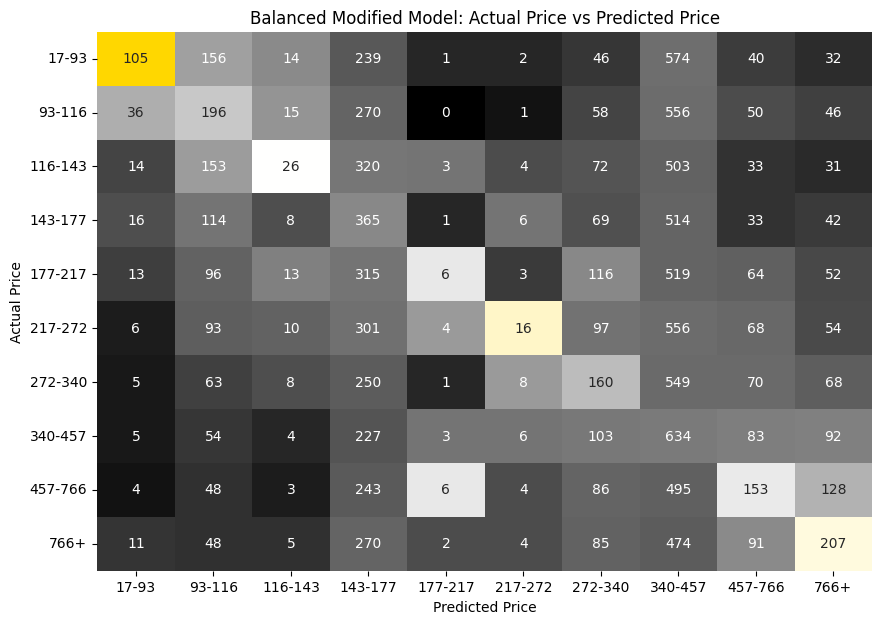

In [342]:
cm_df = pd.DataFrame(balanced_modified_cm, index=balanced_price_list, columns=balanced_price_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Price')
plt.xlabel('Predicted Price')
plt.title('Balanced Modified Model: Actual Price vs Predicted Price')
plt.show()

In [343]:
balanced_modified_accuracy = accuracy_score(true_labels, predicted_labels)
balanced_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
balanced_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
balanced_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
balanced_modified_report = classification_report(true_labels, predicted_labels, target_names=balanced_price_list)

balanced_modified_metrics = pd.DataFrame([{
    'Model': 'Balanced Modified Price Model',
    'Accuracy': balanced_modified_accuracy,
    'Precision': balanced_modified_precision,
    'Recall': balanced_modified_recall,
    'F1 Score': balanced_modified_f1
}])
metrics_df = pd.concat([metrics_df, balanced_modified_metrics], ignore_index=True)


print(f"Balanced Accuracy: {balanced_modified_accuracy}")
print(f"Balanced Precision: {balanced_modified_precision}")
print(f"Balanced Recall: {balanced_modified_recall}")
print(f"Balanced F1 Score: {balanced_modified_f1}")
print(balanced_modified_report)

Balanced Accuracy: 0.15663256749958074
Balanced Precision: 0.23704706877255594
Balanced Recall: 0.1562281048375767
Balanced F1 Score: 0.13062972748010904
              precision    recall  f1-score   support

       17-93       0.49      0.09      0.15      1209
      93-116       0.19      0.16      0.17      1228
     116-143       0.25      0.02      0.04      1159
     143-177       0.13      0.31      0.18      1168
     177-217       0.22      0.01      0.01      1197
     217-272       0.30      0.01      0.03      1205
     272-340       0.18      0.14      0.15      1182
     340-457       0.12      0.52      0.19      1211
     457-766       0.22      0.13      0.16      1170
        766+       0.28      0.17      0.21      1197

   micro avg       0.16      0.16      0.16     11926
   macro avg       0.24      0.16      0.13     11926
weighted avg       0.24      0.16      0.13     11926
 samples avg       0.16      0.16      0.16     11926



## Brand Model Evaluation

In [344]:
brand_list = ['ADIDAS', 'AIR JORDAN', 'BAPESTA', 'NEW BALANCE', 'NIKE', 'YEEZY']

### Original 

In [345]:
true_labels = []
predicted_labels = []

binary_predictions_list = brand_binary_predictions.tolist()
prediction_count = 0

for batch in brand_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(11926, 6)
(11926, 6)


In [346]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
brand_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(brand_cm)

[[1326    3    1    0   11    1]
 [   6 2344    3    0   61    1]
 [   2    5  465    1   12    0]
 [   0    4    0  600    3    0]
 [   3   86    6    1 6763    0]
 [   0    0    0    0    0  218]]


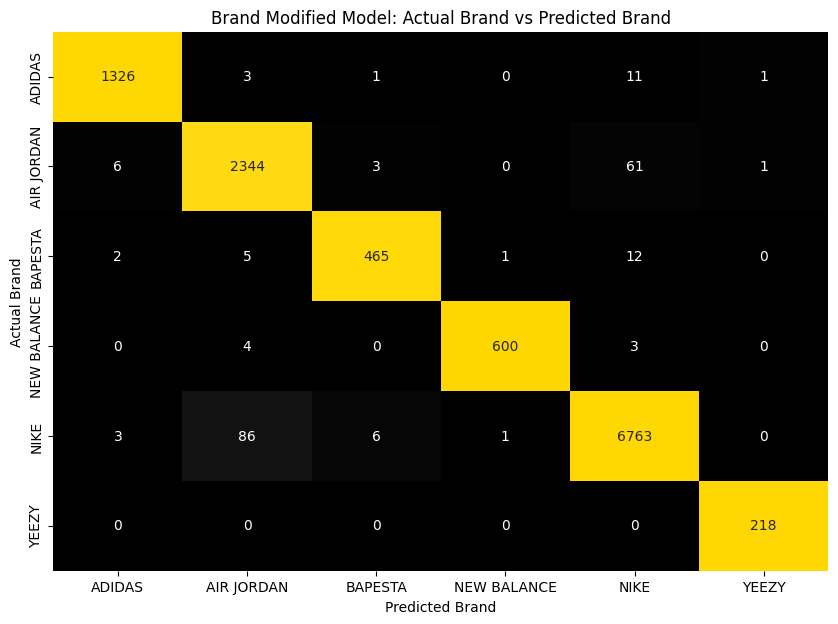

In [347]:
cm_df = pd.DataFrame(brand_cm, index=brand_list, columns=brand_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold"] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Brand')
plt.xlabel('Predicted Brand')
plt.title('Brand Modified Model: Actual Brand vs Predicted Brand')
plt.show()

In [348]:
brand_accuracy = accuracy_score(true_labels, predicted_labels)
brand_precision = precision_score(true_labels, predicted_labels, average='macro')
brand_recall = recall_score(true_labels, predicted_labels, average='macro')
brand_f1 = f1_score(true_labels, predicted_labels, average='macro')
brand_report = classification_report(true_labels, predicted_labels, target_names=brand_list)

brand_metrics = pd.DataFrame([{
    'Model': 'Brand Model',
    'Accuracy': brand_accuracy,
    'Precision': brand_precision,
    'Recall': brand_recall,
    'F1 Score': brand_f1
}])
metrics_df = pd.concat([metrics_df, brand_metrics], ignore_index=True)


print(f"Brand Accuracy: {brand_accuracy}")
print(f"Brand Precision: {brand_precision}")
print(f"Brand Recall: {brand_recall}")
print(f"Brand F1 Score: {brand_f1}")
print(brand_report)

Brand Accuracy: 0.9823914137179273
Brand Precision: 0.9842458425693937
Brand Recall: 0.9819854103974892
Brand F1 Score: 0.9830861996402848
              precision    recall  f1-score   support

      ADIDAS       0.99      0.99      0.99      1342
  AIR JORDAN       0.96      0.97      0.97      2415
     BAPESTA       0.98      0.96      0.97       485
 NEW BALANCE       1.00      0.99      0.99       607
        NIKE       0.99      0.99      0.99      6859
       YEEZY       0.99      1.00      1.00       218

   micro avg       0.98      0.98      0.98     11926
   macro avg       0.98      0.98      0.98     11926
weighted avg       0.98      0.98      0.98     11926
 samples avg       0.98      0.98      0.98     11926



### Modified

In [349]:
true_labels = []
predicted_labels = []

binary_predictions_list = brand_binary_mod_predictions.tolist()
prediction_count = 0

for batch in brand_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(11926, 6)
(11926, 6)


In [350]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
brand_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(brand_modified_cm)

[[1329    2    3    1    6    1]
 [  17 2289    9    5   93    2]
 [   3    5  463    0   14    0]
 [   3    1    0  600    3    0]
 [   9   74   20    1 6755    0]
 [   0    0    0    0    0  218]]


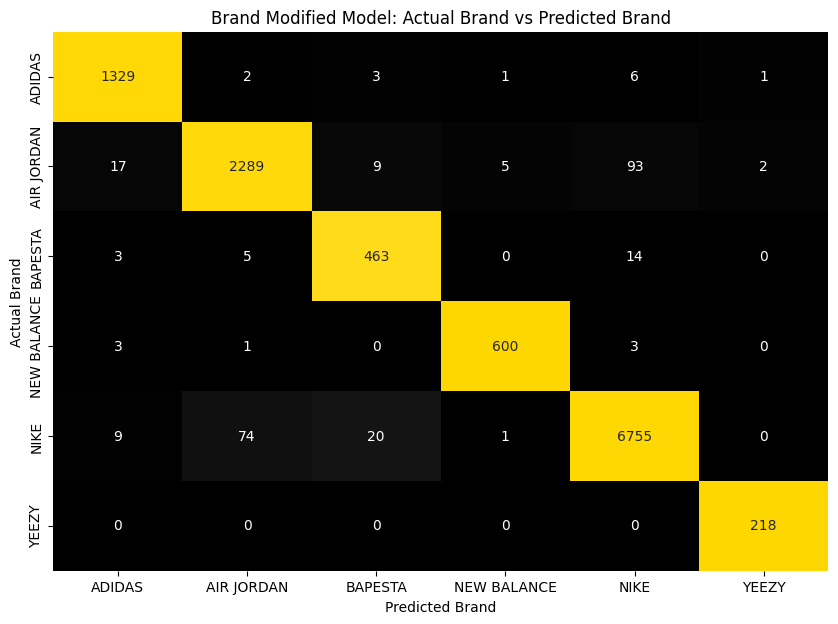

In [351]:
cm_df = pd.DataFrame(brand_modified_cm, index=brand_list, columns=brand_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Brand')
plt.xlabel('Predicted Brand')
plt.title('Brand Modified Model: Actual Brand vs Predicted Brand')
plt.show()

In [352]:
brand_modified_accuracy = accuracy_score(true_labels, predicted_labels)
brand_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
brand_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
brand_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
brand_modified_report = classification_report(true_labels, predicted_labels, target_names=brand_list)

brand_modified_metrics = pd.DataFrame([{
    'Model': 'Brand Modified Model',
    'Accuracy': brand_modified_accuracy,
    'Precision': brand_modified_precision,
    'Recall': brand_modified_recall,
    'F1 Score': brand_modified_f1
}])
metrics_df = pd.concat([metrics_df, brand_modified_metrics], ignore_index=True)


print(f"Brand Modified Accuracy: {brand_modified_accuracy}")
print(f"Brand Modified Precision: {brand_modified_precision}")
print(f"Brand Modified Recall: {brand_modified_recall}")
print(f"Brand Modified F1 Score: {brand_modified_f1}")
print(brand_modified_report)

Brand Modified Accuracy: 0.9771926882441724
Brand Modified Precision: 0.9725445854588269
Brand Modified Recall: 0.9776805904318605
Brand Modified F1 Score: 0.9750667589549357
              precision    recall  f1-score   support

      ADIDAS       0.98      0.99      0.98      1342
  AIR JORDAN       0.97      0.95      0.96      2415
     BAPESTA       0.94      0.95      0.94       485
 NEW BALANCE       0.99      0.99      0.99       607
        NIKE       0.98      0.98      0.98      6859
       YEEZY       0.99      1.00      0.99       218

   micro avg       0.98      0.98      0.98     11926
   macro avg       0.97      0.98      0.98     11926
weighted avg       0.98      0.98      0.98     11926
 samples avg       0.98      0.98      0.98     11926



## Model Model Evaluation

In [353]:
model_list = ['NB 2002R', 'AIR MAX 1', 'NIKE AIR MAX 90', 'AJ 1','AJ 11', 'AJ 12', 'AJ 2', 
'AJ 3', 'AJ 4', 'AJ 5', 'AJ 6', 'BAPESTA', 'NIKE DUNK LOW','NIKE DUNK HIGH', 'NB550',
'NB990', 'ADIDAS STAN SMITH', 'YZY 700', 'YZY 350', 'YZY RNR', 'NIKE AF1', 
'ADIDAS FORUM', 'ADIDAS SAMBA', 'YZY SLIDES'
]

### Original 

In [354]:
true_labels = []
predicted_labels = []

binary_predictions_list = model_binary_predictions.tolist()
prediction_count = 0

for batch in model_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(11926, 24)
(11926, 24)


In [355]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
model_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(model_cm)


[[ 190    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0  855    9   30    0    0    0    0    0    0    0    5    0    0
     0    0    0    0    0    0   33    0    0    0]
 [   0   12 1033    1    0    0    0    0    0    0    0    2    0    0
     0    0    0    0    0    0    2    0    0    0]
 [   0   13    0 1300    0    0    4    1    0   14    0    5   14    3
     0    0   10    1    0    0    3    0    0    0]
 [   0    4    0    8  147    0    0    0    0    1    0    1    0    0
     0    0    1    1    0    0    1    0    0    0]
 [   0    4    0    3    0  105    0    0    0    1    0    0    0    0
     0    0    0    0    0    0    3    0    0    0]
 [   0    3    0   53    0    0   70    1    0   13    0    4    0    1
     0    1    2    0    0    0    2    0    0    0]
 [   0    5    0   20    4    0    0  124    1    1    4    5    0    4
     0    0    0    1    0    0    7    0    1    0]


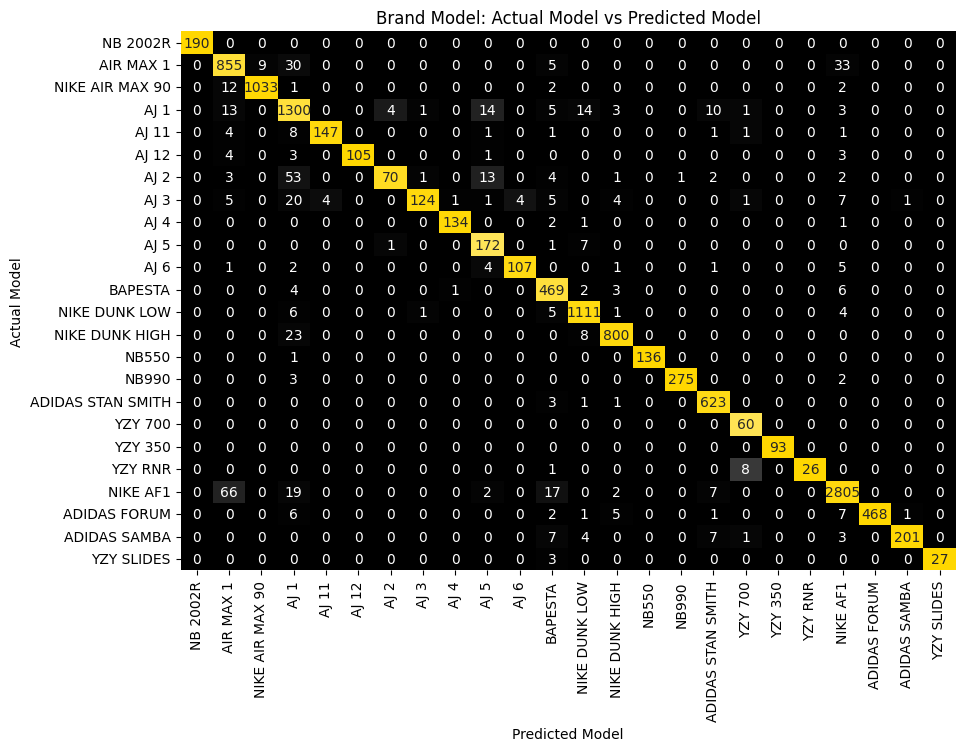

In [356]:
cm_df = pd.DataFrame(model_cm, index=model_list, columns=model_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Model')
plt.xlabel('Predicted Model')
plt.title('Brand Model: Actual Model vs Predicted Model')
plt.show()

In [357]:
model_accuracy = accuracy_score(true_labels, predicted_labels)
model_precision = precision_score(true_labels, predicted_labels, average='macro')
model_recall = recall_score(true_labels, predicted_labels, average='macro')
model_f1 = f1_score(true_labels, predicted_labels, average='macro')
model_report = classification_report(true_labels, predicted_labels, target_names=model_list)

model_metrics = pd.DataFrame([{
    'Model': 'Model Model',
    'Accuracy': model_accuracy,
    'Precision': model_precision,
    'Recall': model_recall,
    'F1 Score': model_f1
}])
metrics_df = pd.concat([metrics_df, model_metrics], ignore_index=True)


print(f"Brand Accuracy: {model_accuracy}")
print(f"Brand Precision: {model_precision}")
print(f"Brand Recall: {model_recall}")
print(f"Brand F1 Score: {model_f1}")
print(model_report)

Brand Accuracy: 0.9501090055341271
Brand Precision: 0.9578542885938198
Brand Recall: 0.9152486878850886
Brand F1 Score: 0.9304488109115508
                   precision    recall  f1-score   support

         NB 2002R       1.00      1.00      1.00       190
        AIR MAX 1       0.89      0.92      0.90       932
  NIKE AIR MAX 90       0.99      0.98      0.99      1050
             AJ 1       0.88      0.95      0.91      1368
            AJ 11       0.97      0.90      0.93       164
            AJ 12       1.00      0.91      0.95       116
             AJ 2       0.93      0.47      0.62       150
             AJ 3       0.98      0.70      0.82       177
             AJ 4       0.99      0.97      0.98       138
             AJ 5       0.83      0.95      0.88       181
             AJ 6       0.96      0.88      0.92       121
          BAPESTA       0.88      0.97      0.92       485
    NIKE DUNK LOW       0.97      0.98      0.98      1128
   NIKE DUNK HIGH       0.97      

### Modified 

In [358]:
true_labels = []
predicted_labels = []

binary_predictions_list = model_binary_mod_predictions.tolist()
prediction_count = 0

for batch in model_predictions_dataset:
    images, labels = batch
    for i in range(len(labels)):
        true_label = labels[i].numpy()
        true_labels.append(true_label)
        predicted_label = np.array(binary_predictions_list[prediction_count])
        predicted_labels.append(predicted_label)
        prediction_count += 1

true_labels_np = np.array(true_labels)
predicted_labels_np = np.array(predicted_labels)
print(true_labels_np.shape)
print(predicted_labels_np.shape)

(11926, 24)
(11926, 24)


In [359]:
true_labels_1d = np.argmax(true_labels_np, axis=1)
predicted_labels_1d = np.argmax(predicted_labels_np, axis=1)
model_modified_cm = confusion_matrix(true_labels_1d, predicted_labels_1d)
print(model_modified_cm)

[[ 190    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0]
 [   0  820    4   30    0    0    1    0    0    0    0    0    0    0
     0    0    0    1    0    0   76    0    0    0]
 [   0    7 1036    2    0    0    0    0    0    0    0    1    0    0
     0    0    0    0    0    0    2    1    1    0]
 [   0   14    0 1303    0    0    8    0    0    4    0    4    4    3
     0    0   10    0    0    0   15    2    1    0]
 [   0    3    0    6  152    0    0    0    1    0    0    0    0    1
     0    0    0    0    0    0    1    0    0    0]
 [   1    1    0    2    0  106    0    0    0    0    1    0    0    0
     0    0    0    0    0    0    4    1    0    0]
 [   0    0    0   54    1    0   86    0    0    0    0    1    0    0
     1    0    1    0    0    0    3    1    2    0]
 [   0    1    0    9    5    0    0  150    0    0    5    0    0    0
     0    0    1    0    0    0    5    0    1    0]


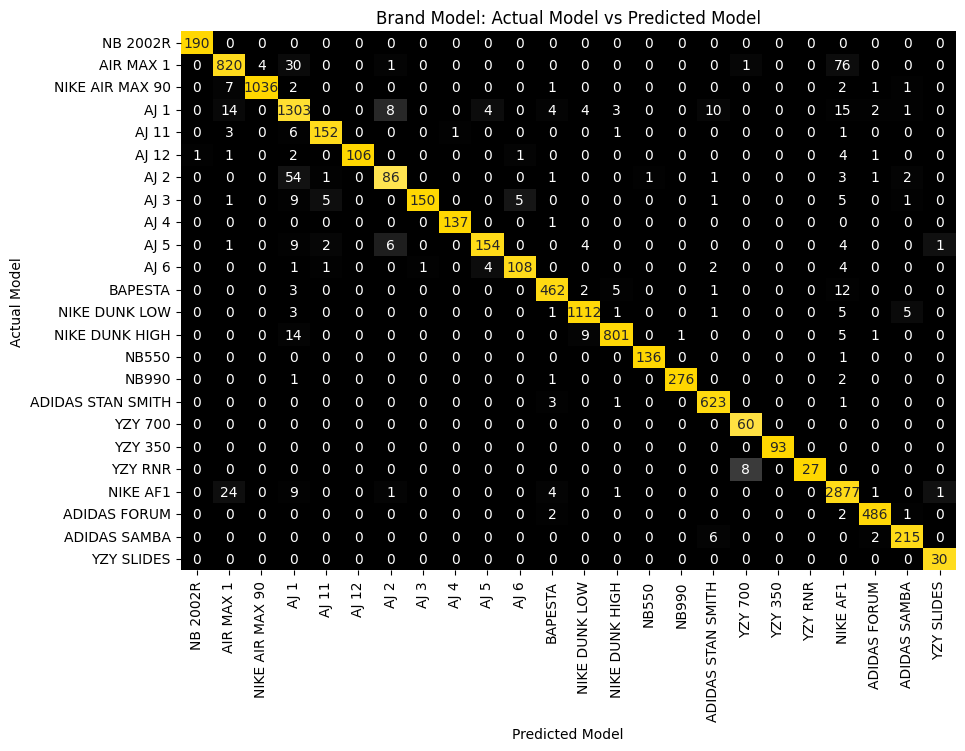

In [360]:
cm_df = pd.DataFrame(model_modified_cm, index=model_list, columns=model_list)

cm_df_normalized = cm_df.div(cm_df.sum(axis=0), axis=1)

colors = ["black", "white", "gold", ] 
cmap = LinearSegmentedColormap.from_list("BlGdBr", colors)

plt.figure(figsize=(10, 7))
ax = sns.heatmap(cm_df_normalized, annot=True, fmt=".2f", cbar=False, cmap=cmap)

for i in range(cm_df.shape[0]):
    for j in range(cm_df.shape[1]):
        text = ax.texts[i * cm_df.shape[1] + j]
        text.set_text(int(cm_df.iloc[i, j]))

plt.ylabel('Actual Model')
plt.xlabel('Predicted Model')
plt.title('Brand Model: Actual Model vs Predicted Model')
plt.show()

In [362]:
model_modified_accuracy = accuracy_score(true_labels, predicted_labels)
model_modified_precision = precision_score(true_labels, predicted_labels, average='macro')
model_modified_recall = recall_score(true_labels, predicted_labels, average='macro')
model_modified_f1 = f1_score(true_labels, predicted_labels, average='macro')
model_modified_report = classification_report(true_labels, predicted_labels, target_names=model_list)

model_modified_metrics = pd.DataFrame([{
    'Model': 'Modified Model Model',
    'Accuracy': model_modified_accuracy,
    'Precision': model_modified_precision,
    'Recall': model_modified_recall,
    'F1 Score': model_modified_f1
}])
metrics_df = pd.concat([metrics_df, model_modified_metrics], ignore_index=True)

print(f"Brand Accuracy: {model_modified_accuracy}")
print(f"Brand Precision: {model_modified_precision}")
print(f"Brand Recall: {model_modified_recall}")
print(f"Brand F1 Score: {model_modified_f1}")
print(model_modified_report)

Brand Accuracy: 0.9592487003186315
Brand Precision: 0.9618301186719344
Brand Recall: 0.9333584677332736
Brand F1 Score: 0.9451002840445212
                   precision    recall  f1-score   support

         NB 2002R       0.99      1.00      1.00       190
        AIR MAX 1       0.94      0.88      0.91       932
  NIKE AIR MAX 90       1.00      0.99      0.99      1050
             AJ 1       0.90      0.95      0.93      1368
            AJ 11       0.94      0.93      0.94       164
            AJ 12       1.00      0.91      0.95       116
             AJ 2       0.84      0.57      0.68       150
             AJ 3       0.99      0.85      0.91       177
             AJ 4       0.99      0.99      0.99       138
             AJ 5       0.95      0.85      0.90       181
             AJ 6       0.95      0.89      0.92       121
          BAPESTA       0.96      0.95      0.96       485
    NIKE DUNK LOW       0.98      0.99      0.98      1128
   NIKE DUNK HIGH       0.99      

# ALL MODELS

In [366]:
metrics_df.head(10)

,Model,Accuracy,Precision,Recall,F1 Score
0,Unbalanced Price Model,0.355106,0.304498,0.168847,0.165900
1,Unbalanced Modified Price Model,0.356951,0.269568,0.163554,0.163124
2,Balanced Price Model,0.196462,0.243489,0.196812,0.182338
3,Balanced Modified Price Model,0.156633,0.237047,0.156228,0.130630
4,Brand Model,0.982391,0.984246,0.981985,0.983086
5,Brand Modified Model,0.977193,0.972545,0.977681,0.975067
6,Model Model,0.950109,0.957854,0.915249,0.930449
7,Modified Model Model,0.959249,0.961830,0.933358,0.945100


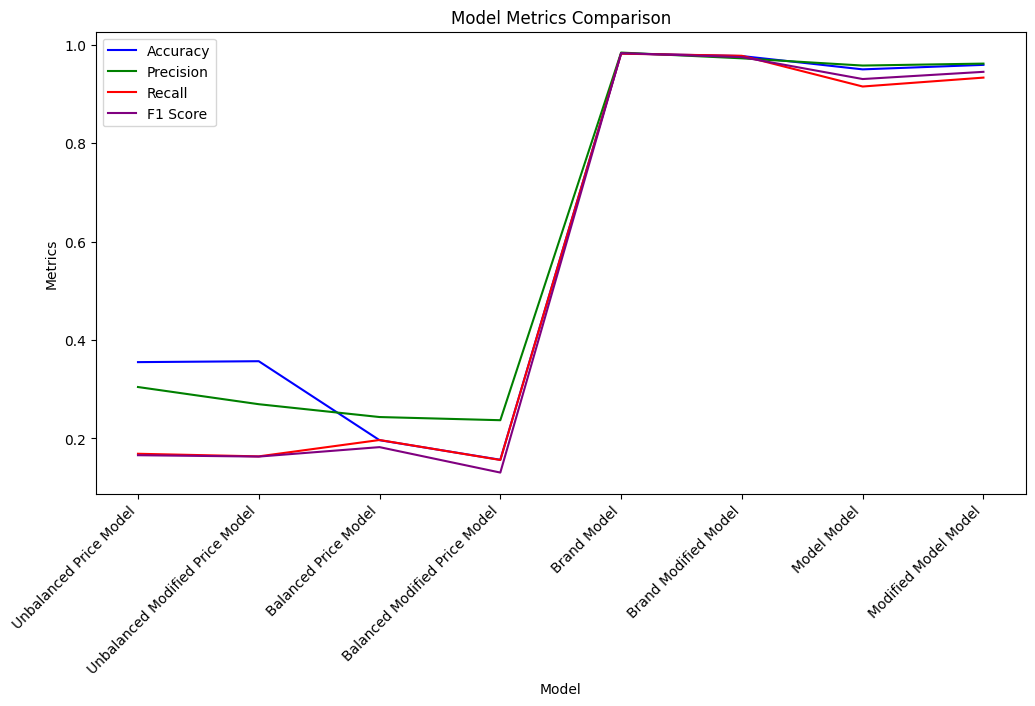

In [384]:
plt.figure(figsize=(12, 6))
plt.plot(metrics_df['Model'], metrics_df['Accuracy'], color='blue', label='Accuracy')
plt.plot(metrics_df['Model'], metrics_df['Precision'], color='green', label='Precision')
plt.plot(metrics_df['Model'], metrics_df['Recall'], color='red', label='Recall')
plt.plot(metrics_df['Model'], metrics_df['F1 Score'], color='purple', label='F1 Score')
plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Model Metrics Comparison')
plt.xticks(rotation=45, ha="right") 
plt.legend()  
plt.show()